# 18기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.
데이터셋 출처 :  https://www.kaggle.com/datasets/shenba/time-series-datasets

### Box-Jenkins 방법론
![image.png](attachment:image.png)
대략적 흐름 예시를 확인하고 싶다면 첨부한 '시계열자료_참고자료.pdf'를 읽어주세요.

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [4]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 불러오기

In [28]:
df = pd.read_csv('./Electric_Production.csv')
df['DATE']=pd.to_datetime(df['DATE'],infer_datetime_format=True)
df.rename(columns={'DATE':'ds','IPG2211A2N':'y'},inplace=True) # Dataframe must have columns "ds" and "y" with the dates and values respectively.
df.head()

,ds,y
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [12]:
!pip install pystan==2.19.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 105 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0


In [13]:
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6639358 sha256=7772fb26d0e6dcfaf693843a813ee365e33443216b448b5e4d023bd96b60b5ad
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet


## 결측치 확인

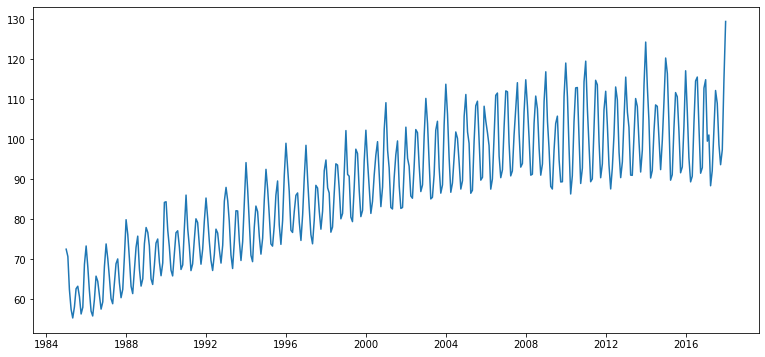

In [20]:
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 13, 6 
plt.plot(df) 

In [24]:
df.isnull().sum()

IPG2211A2N    0
dtype: int64

## Prophet 사용

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


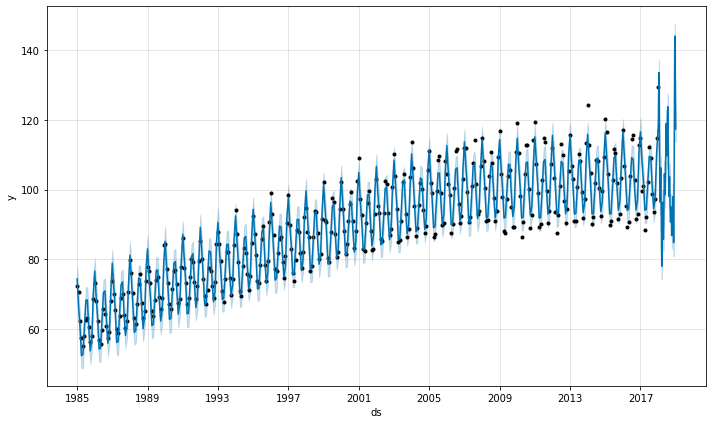

In [51]:
from fbprophet import Prophet

m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365) # 향후 365일의 실적 예측
forecast = m.predict(future)
fig1 = m.plot(forecast)

파란색 선: 모델이 예측한 값\
검정색 점: 실제 데이터\
변동폭이 갑작스럽게 커져 패턴을 잘 잡아내고 있지 않은 것으로 보임. 

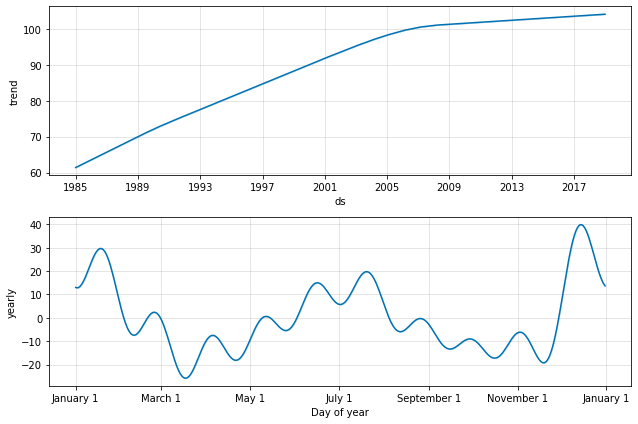

In [34]:
fig2 = m.plot_components(forecast)

Trend : 점점 증가하다가 2008년부터 급격하게 완만한 증가 기울기를 가지는 추세를 보임\
Yearly : 1월에 가장 높다

### Trend

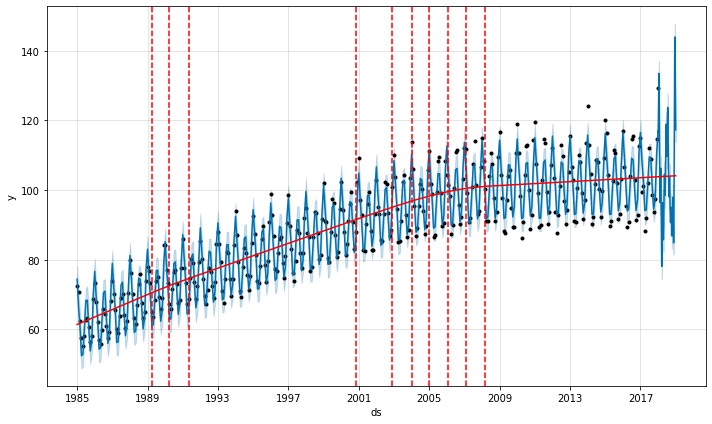

In [35]:
from fbprophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

changepoints : 트렌드 변화시점을 명시한 리스트값\
changepoint의 값 변경에 따른 Trend 변화를 보여주는 그래프\
빨간 실선 : 트렌드\
빨간 점선 : 트렌드가 변화하는 changepoint

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


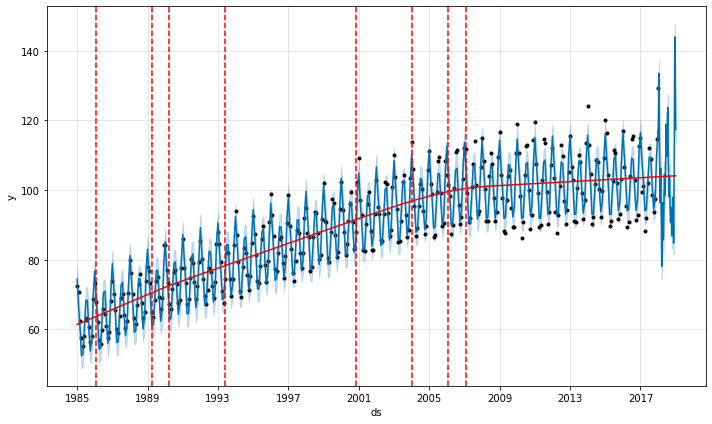

In [40]:
m = Prophet(changepoint_prior_scale=0.2)
m.fit(df)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### Seasonality

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


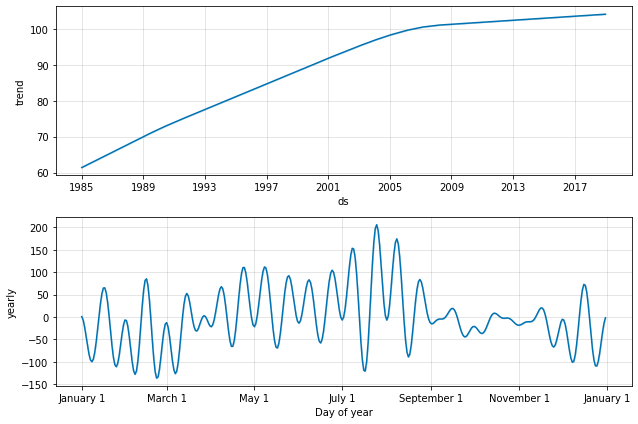

In [44]:
m = Prophet(
    # trend
    changepoint_prior_scale=0.2,
    # seasonality
    yearly_seasonality=30,
    daily_seasonality=False
)

m.fit(df)
fig = m.plot_components(forecast)

yearly_seasonality 값을 30으로 높여준 결과, 연 주기 패턴을 더 유연하게 잡음

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


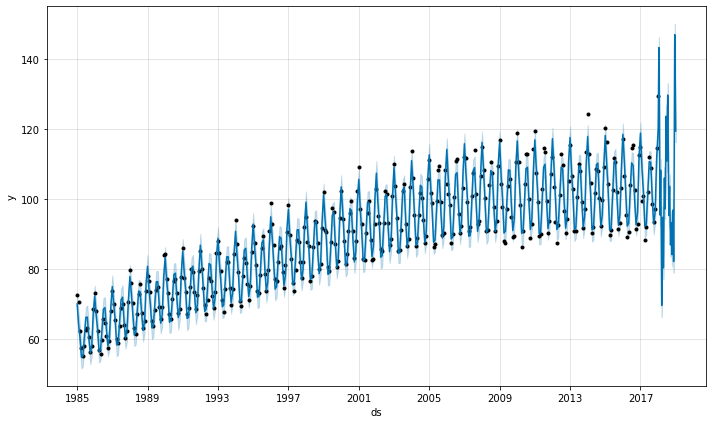

In [47]:
m = Prophet(
    # trend
    changepoint_prior_scale=0.2,
    # seasonality
    yearly_seasonality=10,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

m.fit(df)
forecast = m.predict(future)
fig1 = m.plot(forecast)

Additive (데이터의 진폭이 일정) 인지 Multiplicative (데이터의 진폭이 점점 증가하거나 감소) 인지 알아봄\
default 값인 additive의 그래프와 큰 차이를 보이지 않기 때문에 Multiplicative한 특성이 강하지 않다고 볼 수 있음